In [ ]:
import tensorflow as tf

In [ ]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
from PIL import Image
from IPython import display
from google.colab import drive
import pandas as pd

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp /content/drive/MyDrive/celeb_dataset.zip /content/

In [ ]:
!unzip /content/celeb_dataset.zip -d /content/dataset/

Streaming output truncated to the last 5000 lines.
 extracting: /content/dataset/img_align_celeba/197600.jpg  
 extracting: /content/dataset/img_align_celeba/197601.jpg  
 extracting: /content/dataset/img_align_celeba/197602.jpg  
 extracting: /content/dataset/img_align_celeba/197603.jpg  
 extracting: /content/dataset/img_align_celeba/197604.jpg  
 extracting: /content/dataset/img_align_celeba/197605.jpg  
 extracting: /content/dataset/img_align_celeba/197606.jpg  
 extracting: /content/dataset/img_align_celeba/197607.jpg  
 extracting: /content/dataset/img_align_celeba/197608.jpg  
 extracting: /content/dataset/img_align_celeba/197609.jpg  
 extracting: /content/dataset/img_align_celeba/197610.jpg  
 extracting: /content/dataset/img_align_celeba/197611.jpg  
 extracting: /content/dataset/img_align_celeba/197612.jpg  
 extracting: /content/dataset/img_align_celeba/197613.jpg  
 extracting: /content/dataset/img_align_celeba/197614.jpg  
 extracting: /content/dataset/img_align_celeba/19

In [ ]:
dataset_dir = '/content/dataset/img_align_celeba'

In [ ]:
image_files = sorted([f for f in os.listdir(dataset_dir) if os.path.isfile(os.path.join(dataset_dir, f))])


In [ ]:
img_height, img_width = 28, 28

In [ ]:

images = []
for file in image_files:
    # Construct the full path to the image file
    img_path = os.path.join(dataset_dir, file)

    # Open the image using PIL
    img = Image.open(img_path).convert('L')  # Convert to grayscale
    img = img.resize((img_height, img_width))  # Resize to desired dimensions
    img_array = np.array(img)  # Convert to NumPy array

    # Append the image array to the list
    images.append(img_array)

# Convert the list of images to a NumPy array
images_np = np.array(images)





In [ ]:
images_np = images_np.reshape(images_np.shape[0], 28, 28, 1).astype('float32')

In [ ]:
#normalizing images
images_np = (images_np - 127.5) / 127.5


print('Shape of images array:', images_np.shape)

Shape of images array: (202599, 28, 28, 1)


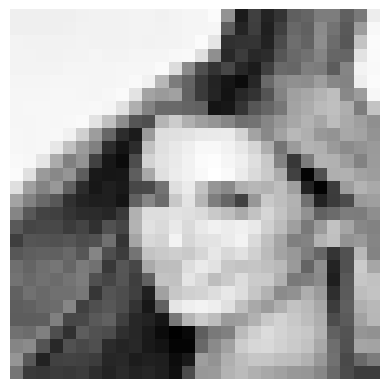

In [ ]:
plt.imshow(images_np[0].reshape(28, 28), cmap='gray')
plt.axis('off')
plt.show()

In [ ]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices(images_np).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
#generator model

def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12544)             1254400   
                                                                 
 batch_normalization (Batch  (None, 12544)             50176     
 Normalization)                                                  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 12544)             0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 7, 7, 128)         819200    
 anspose)                                                        
                                                                 
 batch_normalization_1 (Bat  (None, 7, 7, 128)         5

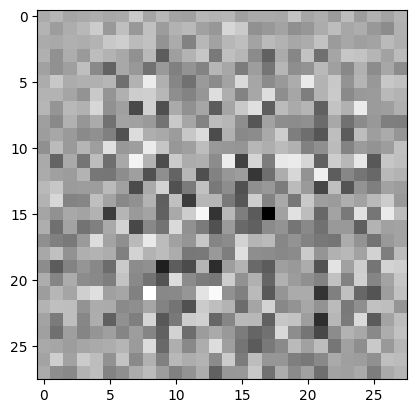

In [ ]:
generator = make_generator_model()
print(generator.summary())
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [ ]:
#discriminator model
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [ ]:
discriminator = make_discriminator_model()
discriminator.summary()
decision = discriminator(generated_image)
print (decision)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten (Flatten)           (None, 6272)             

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss, real_loss, fake_loss

In [ ]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [ ]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [ ]:

@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss, real_loss, fake_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    return gen_loss, disc_loss, real_loss, fake_loss

In [ ]:
def train(dataset, epochs):
  gen_hist = []
  disc_hist = []
  disc_real_hist = []
  disc_fake_hist = []
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      g_loss, d_loss, d_real_loss, d_fake_loss = train_step(image_batch)
      g_loss = g_loss.numpy()
      d_loss = d_loss.numpy()
      d_real_loss = d_real_loss.numpy()
      d_fake_loss = d_fake_loss.numpy()
      gen_hist.append(g_loss)
      disc_hist.append(d_loss)
      disc_real_hist.append(d_real_loss)
      disc_fake_hist.append(d_fake_loss)
    print("G_loss:", g_loss, "D_loss:", d_real_loss, d_fake_loss, d_loss)

    # Produce images for the GIF as you go
    # display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  # display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)
  plot_history(disc_real_hist, disc_fake_hist, disc_hist, gen_hist)

In [ ]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [ ]:
def plot_history(d1_hist, d2_hist, d_hist, g_hist):
  # plot loss
  plt.plot(d1_hist, label='d-real')
  plt.plot(d2_hist, label='d-fake')
  plt.plot(d_hist, label='d-total')
  plt.plot(g_hist, label='gen')
  plt.legend()
  # save plot to file
  plt.savefig('plot_loss.png')
  plt.show()
  plt.close()

G_loss: 0.76943564 D_loss: 0.62549824 0.7184768 1.3439751


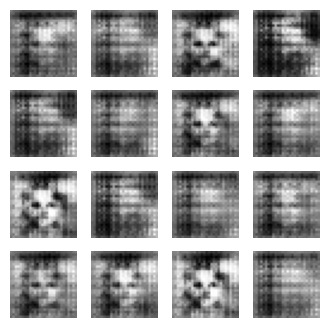

Time for epoch 1 is 46.52793049812317 sec
G_loss: 0.7013209 D_loss: 0.5864104 0.7104434 1.2968538


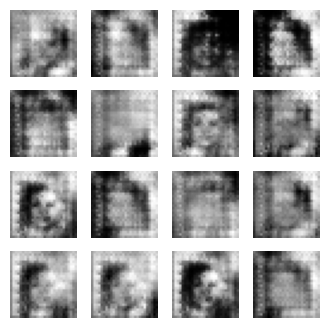

Time for epoch 2 is 38.65658164024353 sec
G_loss: 0.7193513 D_loss: 0.78047854 0.67815304 1.4586315


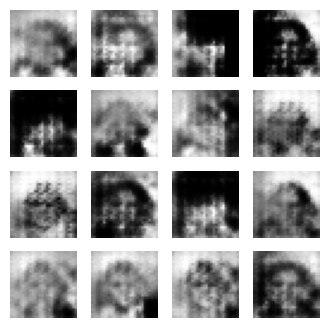

Time for epoch 3 is 41.48133444786072 sec
G_loss: 0.7110309 D_loss: 0.6795932 0.6881313 1.3677244


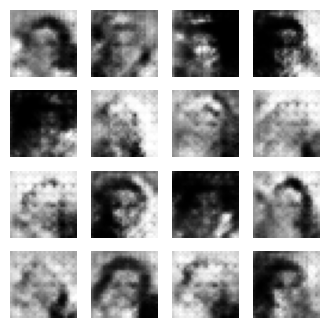

Time for epoch 4 is 38.8795645236969 sec
G_loss: 0.70098424 D_loss: 0.6125323 0.69418097 1.3067133


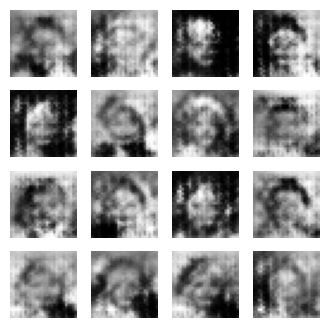

Time for epoch 5 is 41.442545652389526 sec
G_loss: 0.7653194 D_loss: 0.6571137 0.63747585 1.2945895


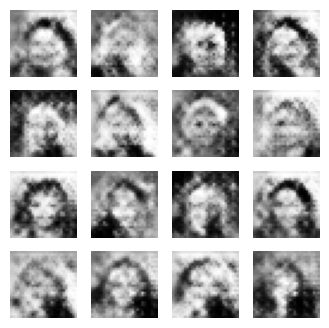

Time for epoch 6 is 39.3508243560791 sec
G_loss: 0.7477865 D_loss: 0.7245927 0.6524217 1.3770144


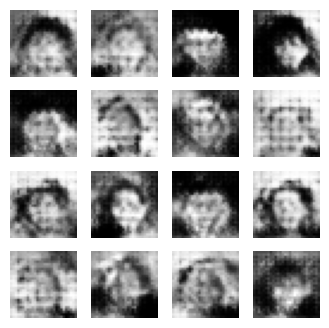

Time for epoch 7 is 41.68713402748108 sec
G_loss: 0.7435662 D_loss: 0.64561164 0.6563961 1.3020077


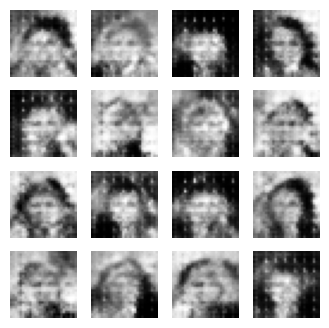

Time for epoch 8 is 38.836345195770264 sec
G_loss: 0.9728336 D_loss: 0.5454116 0.5099263 1.0553379


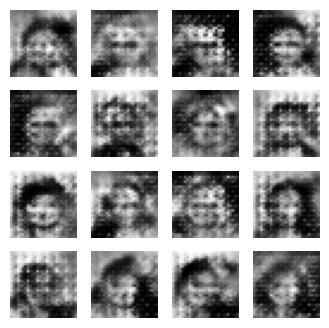

Time for epoch 9 is 38.822031021118164 sec
G_loss: 0.67657083 D_loss: 0.6765416 0.7308496 1.4073913


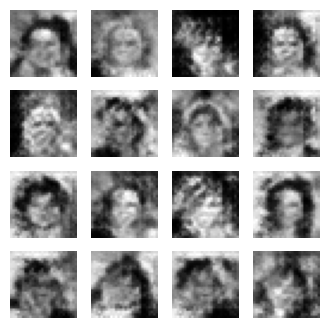

Time for epoch 10 is 41.72307252883911 sec
G_loss: 0.7449766 D_loss: 0.6161087 0.6724005 1.2885091


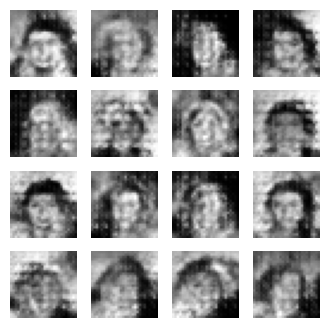

Time for epoch 11 is 41.46825695037842 sec
G_loss: 0.78615713 D_loss: 0.68628025 0.6317719 1.3180522


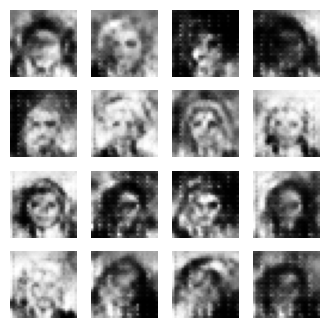

Time for epoch 12 is 39.0420138835907 sec
G_loss: 0.7774796 D_loss: 0.65803 0.653381 1.3114109


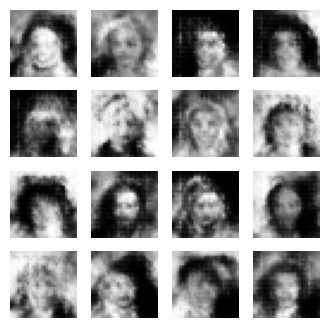

Time for epoch 13 is 38.68438935279846 sec
G_loss: 0.75656813 D_loss: 0.6174902 0.66597164 1.2834618


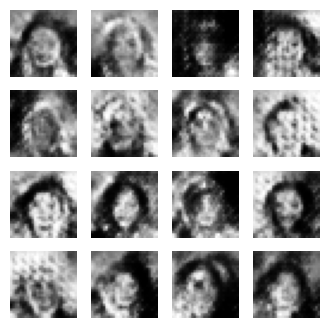

Time for epoch 14 is 39.1028311252594 sec
G_loss: 0.83428484 D_loss: 0.64246297 0.6290184 1.2714814


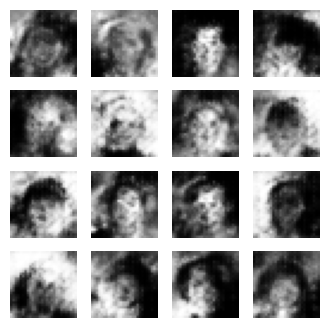

Time for epoch 15 is 38.87335562705994 sec
G_loss: 0.7879605 D_loss: 0.6569336 0.6331007 1.2900343


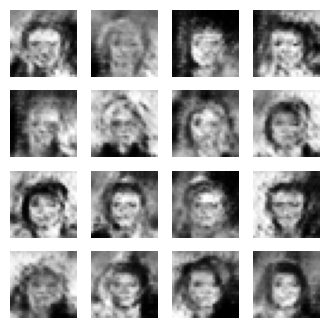

Time for epoch 16 is 39.44772958755493 sec
G_loss: 0.764695 D_loss: 0.7103573 0.7016176 1.4119749


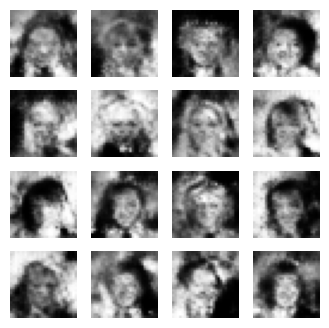

Time for epoch 17 is 38.70467185974121 sec
G_loss: 0.8372941 D_loss: 0.764434 0.630092 1.394526


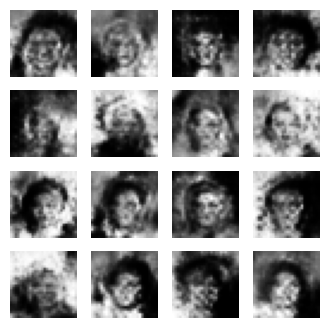

Time for epoch 18 is 39.15091681480408 sec
G_loss: 0.8291426 D_loss: 0.6275198 0.6454838 1.2730036


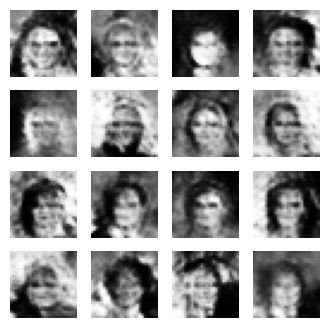

Time for epoch 19 is 41.45264935493469 sec
G_loss: 0.8730314 D_loss: 0.6162292 0.62267834 1.2389076


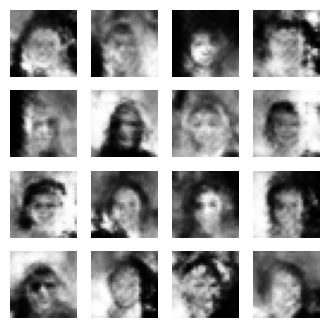

Time for epoch 20 is 41.4434597492218 sec
G_loss: 0.90456903 D_loss: 0.702995 0.61287296 1.3158679


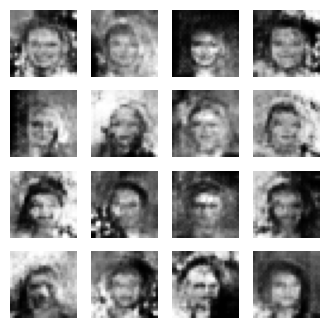

Time for epoch 21 is 41.44963884353638 sec
G_loss: 0.94249946 D_loss: 0.6851675 0.5804257 1.2655932


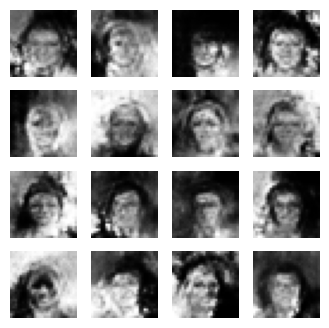

Time for epoch 22 is 41.716994285583496 sec
G_loss: 0.8742522 D_loss: 0.6131148 0.6286076 1.2417223


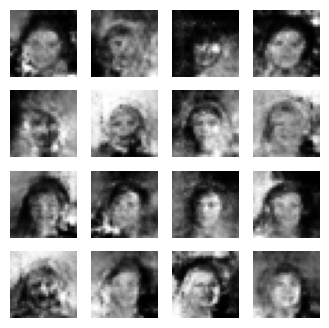

Time for epoch 23 is 41.48007941246033 sec
G_loss: 0.8225146 D_loss: 0.6044373 0.6750351 1.2794724


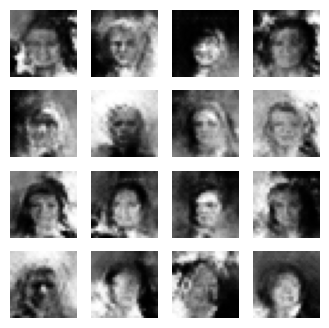

Time for epoch 24 is 39.10213017463684 sec
G_loss: 0.93171024 D_loss: 0.6724008 0.60920674 1.2816075


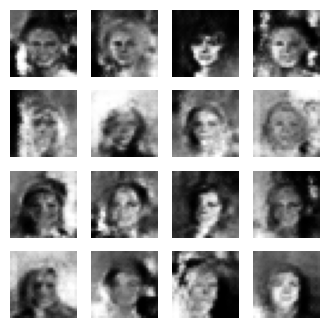

Time for epoch 25 is 38.69932985305786 sec
G_loss: 0.96032065 D_loss: 0.6219016 0.5647354 1.1866369


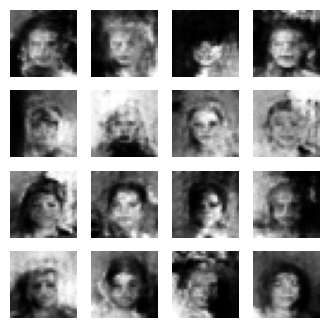

Time for epoch 26 is 38.94115209579468 sec
G_loss: 0.81893516 D_loss: 0.63095176 0.7055273 1.3364791


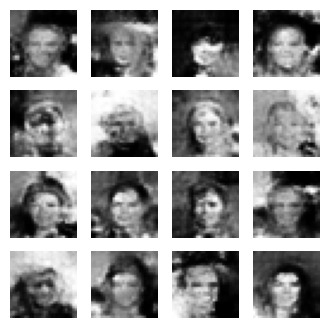

Time for epoch 27 is 41.445687770843506 sec
G_loss: 0.93210286 D_loss: 0.63180715 0.6265689 1.2583761


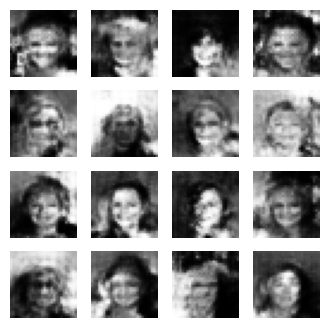

Time for epoch 28 is 39.12863206863403 sec
G_loss: 1.0072753 D_loss: 0.53971815 0.5544834 1.0942016


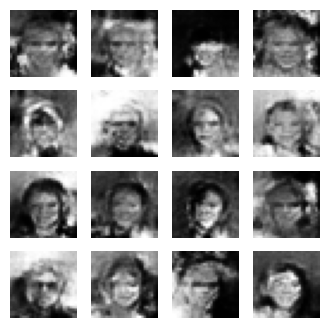

Time for epoch 29 is 38.70197010040283 sec
G_loss: 1.0035805 D_loss: 0.6926306 0.5575246 1.2501552


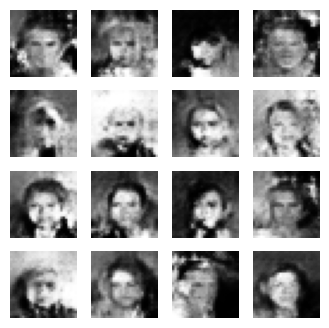

Time for epoch 30 is 38.793697118759155 sec
G_loss: 0.82044214 D_loss: 0.6124582 0.70164335 1.3141016


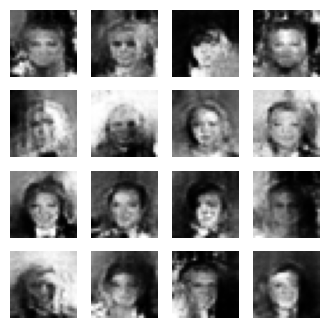

Time for epoch 31 is 38.99072766304016 sec
G_loss: 0.97229075 D_loss: 0.54554677 0.58010936 1.1256561


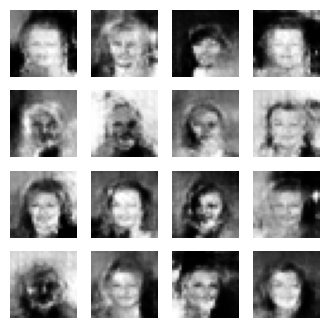

Time for epoch 32 is 38.92046642303467 sec
G_loss: 0.98594177 D_loss: 0.6993726 0.6009149 1.3002875


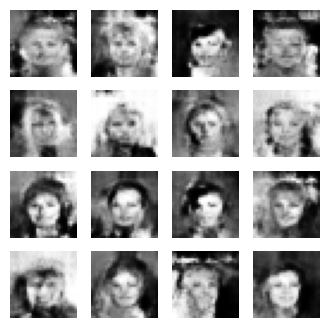

Time for epoch 33 is 38.7203164100647 sec
G_loss: 0.92156756 D_loss: 0.7008625 0.6046086 1.3054712


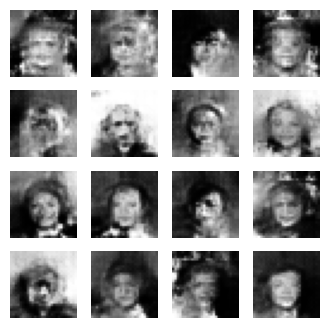

Time for epoch 34 is 38.69560694694519 sec
G_loss: 0.97890145 D_loss: 0.6136984 0.5884011 1.2020996


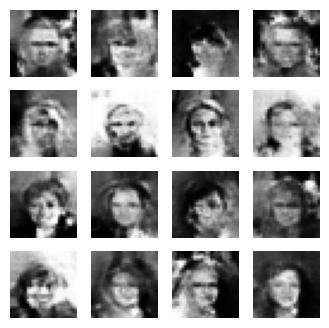

Time for epoch 35 is 41.74672889709473 sec
G_loss: 0.9719532 D_loss: 0.6665191 0.5669154 1.2334344


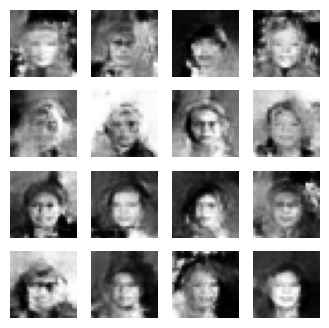

Time for epoch 36 is 41.448888301849365 sec
G_loss: 0.98305345 D_loss: 0.52629644 0.5900024 1.1162989


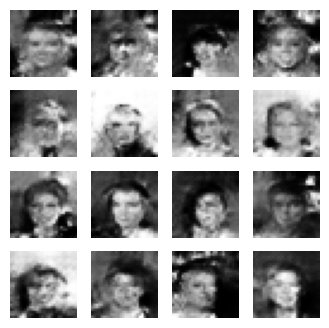

Time for epoch 37 is 41.425270557403564 sec
G_loss: 0.9689481 D_loss: 0.616591 0.592625 1.209216


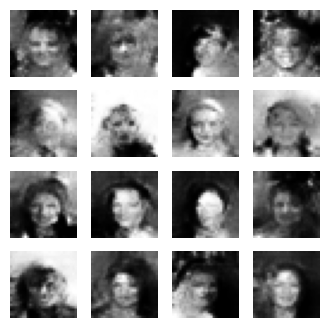

Time for epoch 38 is 39.04743933677673 sec
G_loss: 0.93500674 D_loss: 0.5734814 0.6225825 1.1960639


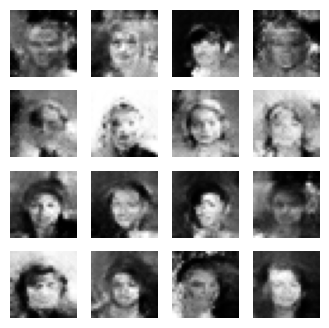

Time for epoch 39 is 38.91217517852783 sec
G_loss: 0.97212994 D_loss: 0.6786471 0.59947014 1.2781172


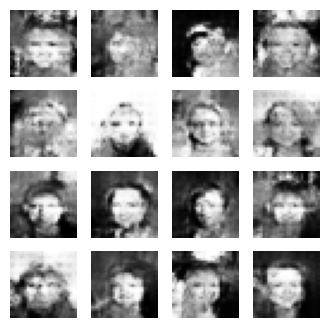

Time for epoch 40 is 38.84885215759277 sec
G_loss: 0.9391283 D_loss: 0.6346914 0.62561834 1.2603097


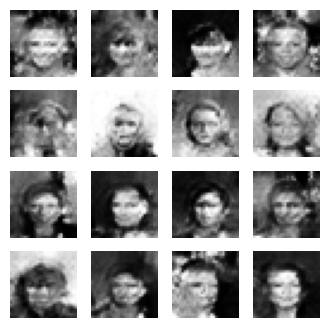

Time for epoch 41 is 39.02692627906799 sec
G_loss: 0.9424107 D_loss: 0.7517124 0.6225836 1.374296


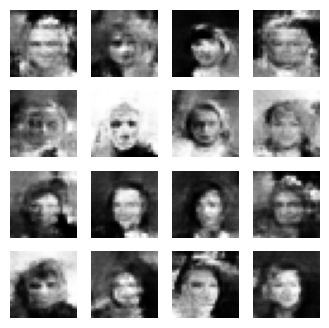

Time for epoch 42 is 38.62601280212402 sec
G_loss: 0.93606234 D_loss: 0.58253217 0.60351485 1.1860471


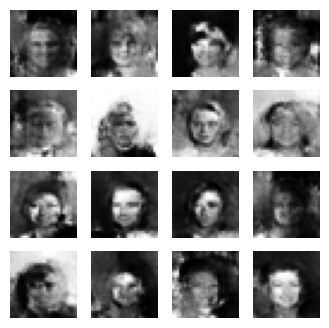

Time for epoch 43 is 38.93215751647949 sec
G_loss: 1.0385782 D_loss: 0.6668332 0.53924745 1.2060807


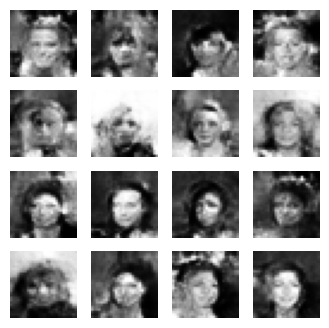

Time for epoch 44 is 38.8116352558136 sec
G_loss: 1.0120593 D_loss: 0.61185205 0.5737765 1.1856285


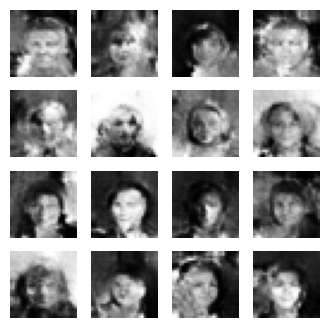

Time for epoch 45 is 41.601319313049316 sec
G_loss: 0.979856 D_loss: 0.6246824 0.58548015 1.2101626


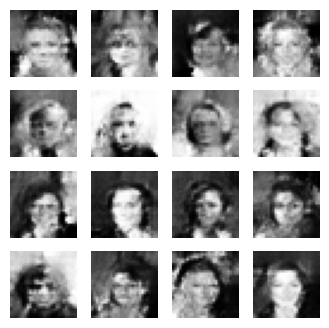

Time for epoch 46 is 38.95169258117676 sec
G_loss: 0.974558 D_loss: 0.64093924 0.5928382 1.2337775


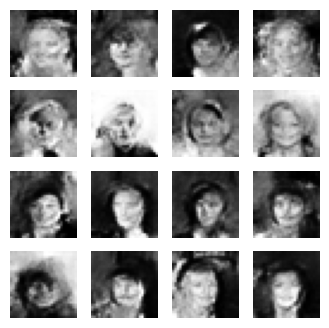

Time for epoch 47 is 39.00406312942505 sec
G_loss: 1.0264345 D_loss: 0.56748074 0.5844697 1.1519504


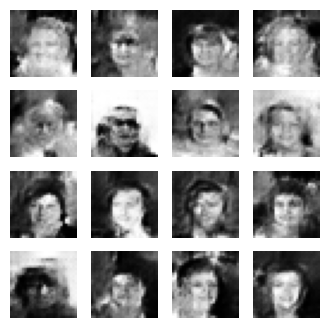

Time for epoch 48 is 38.77026677131653 sec
G_loss: 1.1126102 D_loss: 0.57045275 0.52619064 1.0966434


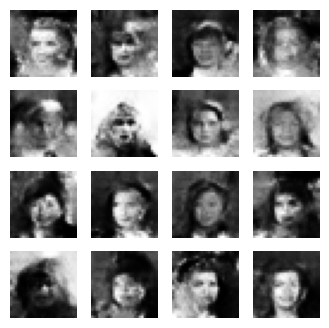

Time for epoch 49 is 41.45074439048767 sec
G_loss: 0.9220476 D_loss: 0.66883636 0.698189 1.3670254


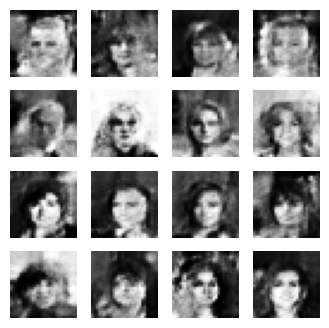

Time for epoch 50 is 39.02733635902405 sec


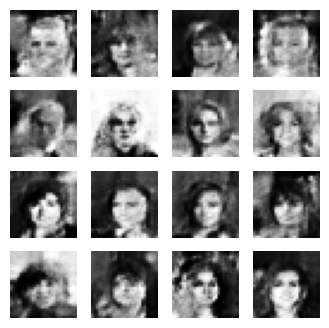

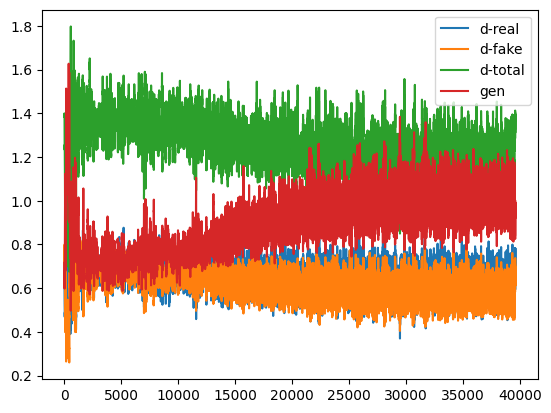

In [ ]:
train(train_dataset, EPOCHS)

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))